In [235]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install bs4 
from bs4 import BeautifulSoup
!pip install lxml
import requests
from datetime import datetime
import seaborn as sb
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression

In [236]:
# Web Scraping
# use requests to open and grab the desired html link
html = requests.get('https://www.baseball-reference.com/leagues/MLB/2018-schedule.shtml').text
# employ BeautifulSoup with an appropriate parser to extract
soup = BeautifulSoup(html, 'lxml')
# find all of the games
gameday = soup.find('p', class_='game')
game = soup.find('h3').text

# function that accepts the date from the website and returns
# it in the correct datetime format
def correctDateTime(date):
  d = date.split(' ', 1)[1:]
  substr1 = d[0].split()[0]
  substr2 = d[0].split()[1]
  # remove the comma
  substr2 = substr2.replace(',', '')
  # create appropriate date string to pass to datetime
  gameday = substr2 + " " + substr1 + ", " + d[0].split()[-1]
  # convert gameday to a datetime called date
  day = datetime.strptime(gameday, "%d %B, %Y").date()
  return day


In [237]:
# first let us create a list to hold the names of all 30 MLB teams
columns = []
# first loop through the schedule to find all MLB teams
schedule = soup.find('div', class_='section_content')
gamedays = schedule.find_all('div')
# iterate through gamedays 
for gameday in gamedays:
  # create a sup-soup of all the games
  games = gameday.find_all('p', class_='game')
  # loop through each game
  for game in games:
    awayTeam = game.find('a').text
    homeTeam = game.find('strong').text
    # fix format of homeTeam
    homeTeam = homeTeam.partition('\n')[0]
    # if the first space is blank, delete it
    if homeTeam[0] == ' ':
      homeTeam = homeTeam[1:]
    # add the home team to the list of teams if it had not
    # already been added to the list
    if awayTeam not in columns:
      columns.append(awayTeam)
    if homeTeam not in columns:
      columns.append(homeTeam)

# now let us loop through schedule to find all of the gamedays and
# we shall store them in gamedates
gamedates = []
for gameday in gamedays: 
  date = correctDateTime(gameday.find('h3').text)
  if date not in gamedates:
    gamedates.append(date)
  

In [241]:
# create dataframe with all 30 MLB teams in the columns and game dates as row indices
gameResults = pd.DataFrame(columns=columns, index=gamedates)

# iterate through gamedays 
for gameday in gamedays:
  date = correctDateTime(gameday.find('h3').text)
  # create a sup-soup of all the games
  games = gameday.find_all('p', class_='game')
  # loop through each game
  for game in games:
    # results of each game
    teams = game.find_all('a')
    awayTeam = teams[0].text
    homeTeam = teams[1].text
    awayRuns = game.text.splitlines()[2]
    homeRuns = game.text.splitlines()[5]
    # remove parentheses and blank spaces
    for i in awayRuns:
      awayRuns = awayRuns.replace('(', '')
      awayRuns = awayRuns.replace(' ', '')
    awayRuns = awayRuns[:-1]
    for i in homeRuns:
      homeRuns = homeRuns.replace('(', '')
      homeRuns = homeRuns.replace(' ', '')
    homeRuns = homeRuns[:-1]

    # make runs ints
    awayRuns = int(awayRuns)
    homeRuns = int(homeRuns)

    # if away team wins
    if awayRuns > homeRuns:
      # create list of info for the winner
      winnerList = [awayRuns, homeRuns]
      # add a +1 label since the game is one
      winnerList.append(1)
      # assign the results to the main dataframe
      gameResults.loc[date][awayTeam] = winnerList
    
      # create list info for loser
      loserList = [homeRuns, awayRuns]
      # add a 0 label reflecting a loss
      loserList.append(0)
      # assign the results to the main dataframe
      gameResults.loc[date][homeTeam] = loserList

    # if home team wins
    elif homeRuns > awayRuns:
      # create list of info for the winner
      winnerList = [homeRuns, awayRuns]
      # add a +1 label since the game is one
      winnerList.append(1)
      # assign the results to the main dataframe
      gameResults.loc[date][homeTeam] = winnerList
    
      # create list info for loser
      loserList = [awayRuns, homeRuns]
      # add a 0 label reflecting a loss
      loserList.append(0)
      # assign the results to the main dataframe
      gameResults.loc[date][awayTeam] = loserList

    gameResults.loc[date][homeTeam] = {'runs_for': gameResults.loc[date, homeTeam][0], 'runs_against': gameResults.loc[date, homeTeam][1], "win/loss": gameResults.loc[date, homeTeam][2]}
    gameResults.loc[date][awayTeam] = {'runs_for': gameResults.loc[date, awayTeam][0], 'runs_against': gameResults.loc[date, awayTeam][1], "win/loss": gameResults.loc[date, awayTeam][2]} 
  
gameResults.head()


,Colorado Rockies,Arizona D'Backs,Philadelphia Phillies,Atlanta Braves,Minnesota Twins,Baltimore Orioles,Chicago White Sox,San Francisco Giants,Chicago Cubs,St. Louis Cardinals,New York Mets,Los Angeles Angels,Oakland Athletics,Milwaukee Brewers,Cleveland Indians,Seattle Mariners,Boston Red Sox,Tampa Bay Rays,Houston Astros,New York Yankees,Washington Nationals,Pittsburgh Pirates,Miami Marlins,Texas Rangers,Los Angeles Dodgers,Toronto Blue Jays,Cincinnati Reds,Kansas City Royals,Detroit Tigers,San Diego Padres
2018-03-29,"{'runs_for': 2, 'runs_against': 8, 'win/loss': 0}","{'runs_for': 8, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 8, 'win/loss': 0}","{'runs_for': 8, 'runs_against': 5, 'win/loss': 1}","{'runs_for': 2, 'runs_against': 3, 'win/loss': 0}","{'runs_for': 3, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 14, 'runs_against': 7, 'win/loss'...","{'runs_for': 1, 'runs_against': 0, 'win/loss': 1}","{'runs_for': 8, 'runs_against': 4, 'win/loss': 1}","{'runs_for': 4, 'runs_against': 9, 'win/loss': 0}","{'runs_for': 9, 'runs_against': 4, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 6, 'runs_against': 5, 'win/loss': 1}","{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}","{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 4, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 6, 'runs_against': 4, 'win/loss': 1}","{'runs_for': 4, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 6, 'runs_against': 1, 'win/loss': 1}",NaN,NaN,"{'runs_for': 4, 'runs_against': 8, 'win/loss': 0}","{'runs_for': 1, 'runs_against': 4, 'win/loss': 0}","{'runs_for': 0, 'runs_against': 1, 'win/loss': 0}","{'runs_for': 1, 'runs_against': 6, 'win/loss': 0}",NaN,"{'runs_for': 7, 'runs_against': 14, 'win/loss'...",NaN,"{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}"
2018-03-30,"{'runs_for': 8, 'runs_against': 9, 'win/loss': 0}","{'runs_for': 9, 'runs_against': 8, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 4, 'win/loss': 1}","{'runs_for': 4, 'runs_against': 5, 'win/loss': 0}",NaN,NaN,NaN,"{'runs_for': 1, 'runs_against': 0, 'win/loss': 1}","{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}",NaN,NaN,"{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}","{'runs_for': 8, 'runs_against': 6, 'win/loss': 1}",NaN,NaN,"{'runs_for': 1, 'runs_against': 0, 'win/loss': 1}","{'runs_for': 0, 'runs_against': 1, 'win/loss': 0}","{'runs_for': 1, 'runs_against': 5, 'win/loss': 0}","{'runs_for': 4, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 2, 'runs_against': 0, 'win/loss': 1}","{'runs_for': 13, 'runs_against': 10, 'win/loss...","{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 0, 'runs_against': 1, 'win/loss': 0}","{'runs_for': 2, 'runs_against': 4, 'win/loss': 0}","{'runs_for': 0, 'runs_against': 2, 'win/loss': 0}",NaN,"{'runs_for': 10, 'runs_against': 13, 'win/loss...","{'runs_for': 6, 'runs_against': 8, 'win/loss': 0}"
2018-03-31,"{'runs_for': 2, 'runs_against': 1, 'win/loss': 1}","{'runs_for': 1, 'runs_against': 2, 'win/loss': 0}","{'runs_for': 2, 'runs_against': 15, 'win/loss'...","{'runs_for': 15, 'runs_against': 2, 'win/loss'...","{'runs_for': 6, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 2, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 4, 'runs_against': 3, 'win/loss': 1}","{'runs_for': 0, 'runs_against': 5, 'win/loss': 0}","{'runs_for': 10, 'runs_against': 6, 'win/loss'...","{'runs_for': 2, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 6, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 8, 'runs_against': 3, 'win/loss': 1}","{'runs_for': 3, 'runs_against': 8, 'win/loss': 0}","{'runs_for': 7, 'runs_against': 3, 'win/loss': 1}","{'runs_for': 6, 'runs_against': 5, 'win/loss': 1}","{'runs_for': 5, 'runs_against': 6, 'win/loss': 0}","{'runs_for': 3, 'runs_against': 2, 'win/loss': 1}","{'runs_for': 2, 'runs_

In [313]:
# make null list
nullList = gameResults.isnull()
# iterate through gamedays 
for i in range(len(gameResults)):
  for j in range(len(gameResults.columns)):
    # ensure that the game is not an off-day (null)
    if nullList.iloc[i][j] == False:
      gameResults.iloc[i][j]['run_differential'] = gameResults.iloc[i][j]['runs_for'] - gameResults.iloc[i][j]['runs_against']
      
for i in range(15, len(gameResults)):
  for j in range(len(gameResults.columns)):
    # make sure game is not an off-day (null)
    if nullList.iloc[i][j] == False:
      # make sure previous game was not an off-day (null)
      # find the most-recent non-off-day
      sum = 0
      # g will be a dummy variable that tracks
      # how far back we go
      g = 0
      for p in range(1,10):
        # make sure the value is non-null
        if nullList.iloc[i-p][j] == False:
          sum += gameResults.iloc[i-p][j]['runs_for']
          # increment g by 1 indicating that we have "found"
          # a previos game
          g +=1
        # stop when g gets to 5 because we only want the last 5 games
        if g > 4:
          break
      # avg = sum/n
      gameResults.iloc[i][j]["5-day_avg_runs"] = sum/5

print('Game Date: ' + str(gameResults.index[-1]))
print('Los Angeles Dodgers\nScore: ' + str(gameResults.iloc[-1]['Los Angeles Dodgers']['runs_for']) \
+ '-' + str(gameResults.iloc[-1]['Los Angeles Dodgers']['runs_against']) + '\nResult(Win/Loss-1/0): '\
+ str(str(gameResults.iloc[-1]['Los Angeles Dodgers']['win/loss'])))
print('Avg. Runs Scored Over Previous 5 Games: ' + str(gameResults.iloc[-1]['Los Angeles Dodgers']['5-day_avg_runs']))

Game Date: 2018-10-01
Los Angeles Dodgers
Score: 5-2
Result(Win/Loss-1/0): 1
Avg. Runs Scored Over Previous 5 Games: 6.6


In [314]:
# aggregate data into one numpy array on which we can employ correlation
winLossList = []
prevGameDiffList = []

# iterate through games by the same procedure as before
for j in range(len(gameResults.columns)):
  for i in range(15, len(gameResults)):
    if nullList.iloc[i][j] == False:
      # append the lists accordingly
      winLossList.append(gameResults.iloc[i][j]['runs_for'])
      prevGameDiffList.append(gameResults.iloc[i][j]['5-day_avg_runs'])

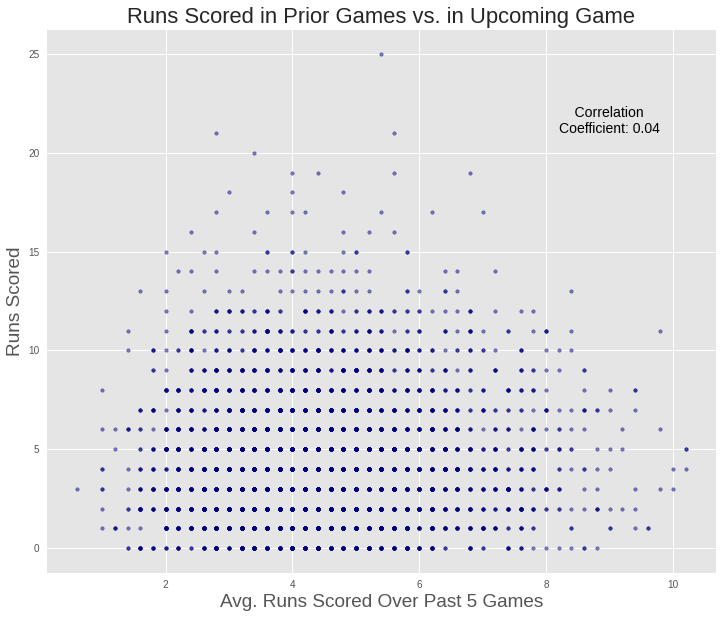

In [287]:
# create releveant numpy arrays
winLossArray = np.array(winLossList)
avgGameDiff = np.array(prevGameDiffList)

plt.scatter(prevGameDiffList, winLossList, marker='.', alpha = .5, color='navy')
plt.gcf().set_size_inches((12,10))
plt.xlabel('Avg. Runs Scored Over Past 5 Games', fontsize = 19)
plt.ylabel('Runs Scored', fontsize = 19)
plt.title('Runs Scored in Prior Games vs. in Upcoming Game', fontsize = 22)
plt.text(8.21, 21, '    Correlation\nCoefficient: ' + str(round(np.corrcoef(winLossArray, avgGameDiff)[1][0], 2)), fontsize=14, color='black')
plt.style.use('ggplot')

plt.show()

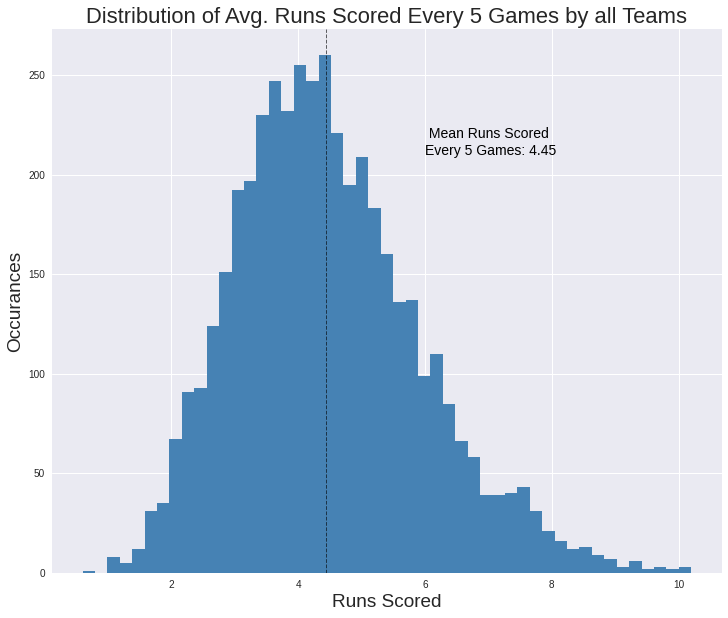

In [311]:
plt.hist(avgGameDiff, bins=49, color='steelblue')
plt.gcf().set_size_inches((12,10))
plt.title('Distribution of Avg. Runs Scored Every 5 Games by all Teams', fontsize = 22)
plt.xlabel('Runs Scored', fontsize=19)
plt.ylabel('Occurances', fontsize=19)
plt.style.use('seaborn')
plt.axvline(avgGameDiff.mean(), color='k', linestyle='dashed', alpha = 0.6, linewidth=1)
plt.text(6, 210, ' Mean Runs Scored\nEvery 5 Games: ' + str(round(avgGameDiff.mean(), 2)), fontsize=14, color='black')
plt.show()

(-0.3, 0.3)

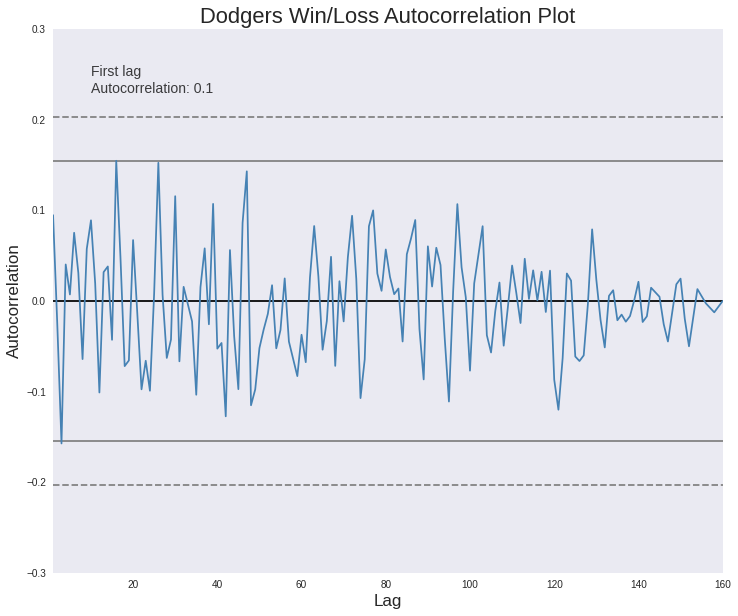

In [310]:
# create lists to hold win/loss info and iterate through the 
# dataframe like before
DodgersWinLoss = []
DodgersWinLossIndex = []
for i in range(len(gameResults)):
  if nullList.iloc[i]['Los Angeles Dodgers'] == False:
    DodgersWinLoss.append(gameResults.iloc[i]['Los Angeles Dodgers']['win/loss'])
    DodgersWinLossIndex.append(gameResults.index[i])

first = np.array(DodgersWinLoss[:-1])
second = np.array(DodgersWinLoss[1:])

autocorrelation_plot(DodgersWinLoss, color='steelblue')
plt.title('Dodgers Win/Loss Autocorrelation Plot', fontsize=22)
plt.gcf().set_size_inches((12,10))
plt.style.use('seaborn')
plt.ylabel('Autocorrelation', fontsize=17)
plt.xlabel('Lag', fontsize=17)
plt.text(10, .23, 'First lag\nAutocorrelation: ' + str(round((np.corrcoef(first, second))[0][1], 2)), fontsize=14, color='black', alpha =.75)
plt.ylim(-.3,.3)


In [309]:
# ARIMA Output
ARIMA_model = ARIMA(DodgersWinLoss, order=(5,0,0))
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  160
Model:                     ARMA(5, 0)   Log Likelihood                -111.963
Method:                       css-mle   S.D. of innovations              0.487
Date:                Mon, 08 Mar 2021   AIC                            237.926
Time:                        02:39:41   BIC                            259.452
Sample:                             0   HQIC                           246.667
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5562      0.038     14.640      0.000       0.482       0.631
ar.L1.y        0.1047      0.079      1.321      0.188      -0.051       0.260
ar.L2.y       -0.0206      0.080     -0.258      0.7

['Colorado Rockies', "Arizona D'Backs", 'Philadelphia Phillies', 'Atlanta Braves', 'Minnesota Twins', 'Baltimore Orioles', 'Chicago White Sox', 'San Francisco Giants', 'Chicago Cubs', 'St. Louis Cardinals', 'New York Mets', 'Los Angeles Angels', 'Oakland Athletics', 'Milwaukee Brewers', 'Cleveland Indians', 'Seattle Mariners', 'Boston Red Sox', 'Tampa Bay Rays', 'Houston Astros', 'New York Yankees', 'Washington Nationals', 'Pittsburgh Pirates', 'Miami Marlins', 'Texas Rangers', 'Los Angeles Dodgers', 'Toronto Blue Jays', 'Cincinnati Reds', 'Kansas City Royals', 'Detroit Tigers', 'San Diego Padres']


[]

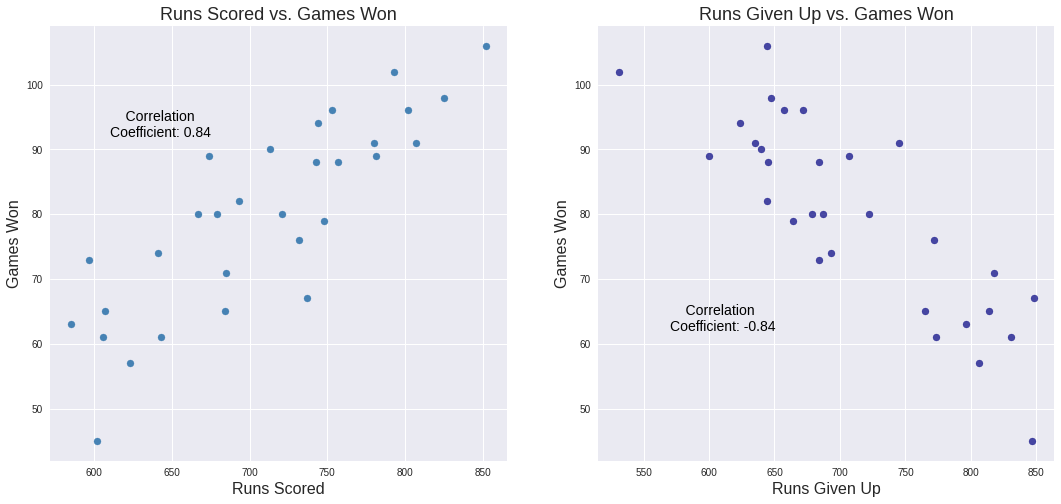

In [340]:
# dump all of the team names into a list
teams = []
for i in range(len(gameResults.columns)):
  teams.append(gameResults.columns[i])

# create dictionaries
wins = {}
runsFor = {}
runsAgainst = {}

# fill in the number of wins, runs for, and runs against
for i in range(len(teams)):
  wins[teams[i]] = 0
for i in range(len(teams)):
  runsFor[teams[i]] = 0
for i in range(len(teams)):
  runsAgainst[teams[i]] = 0

# create a nullList for future checking
# loop through the results and increment each dictionary
nullList = gameResults.isnull()
for i in range(len(gameResults)):
  for j in range(len(teams)):
    if nullList.iloc[i][j] == False: 
      wins[teams[j]] += gameResults.iloc[i][j]['win/loss']
for i in range(len(gameResults)):
  for j in range(len(teams)):
    if nullList.iloc[i][j] == False: 
      runsFor[teams[j]] += gameResults.iloc[i][j]['runs_for']
for i in range(len(gameResults)):
  for j in range(len(teams)):
    if nullList.iloc[i][j] == False: 
      runsAgainst[teams[j]] += gameResults.iloc[i][j]['runs_against']

# create dummy lists so that we can create numpy arrays 
# to perform subsequent operations on
list1 = []
for key, value in wins.items():
  list1.append(value)
winNum = np.array(list1)
list2 = []
for key, value in runsFor.items():
  list2.append(value)
runNum = np.array(list2)
list3 = []
for key, value in runsAgainst.items():
  list3.append(value)
runsAgainstNum = np.array(list3)

# plot both scatter charts and show correlations
fig = plt.figure()
plt.subplot(1,2,1)
plt.scatter(runNum, winNum, color='steelblue')
plt.xlabel('Runs Scored', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Runs Scored vs. Games Won', fontsize = 18)
plt.text(610, 92, '    Correlation\nCoefficient: ' + str(round(np.corrcoef(winNum, runNum)[1][0], 2)), fontsize=14, color='black')
plt.style.use('seaborn')
plt.plot()

plt.subplot(1,2,2)
plt.scatter(runsAgainstNum, winNum, alpha = .7, color='navy')
plt.gcf().set_size_inches((18,8))
plt.xlabel('Runs Given Up', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Runs Given Up vs. Games Won', fontsize = 18)
plt.text(570, 62, '    Correlation\nCoefficient: ' + str(round(np.corrcoef(winNum, runsAgainstNum)[1][0], 2)), fontsize=14, color='black')
plt.style.use('seaborn')
plt.plot()


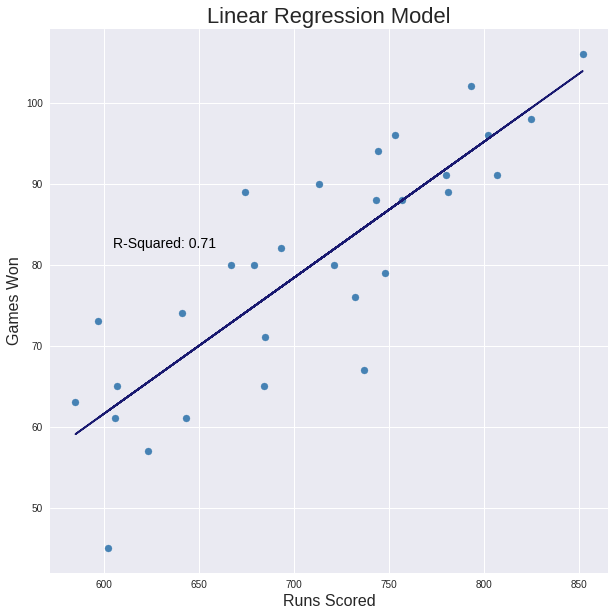

In [345]:
# Linear Regression
X = runNum[:, np.newaxis]
model = LinearRegression(fit_intercept=True)
model.fit(X, winNum)
predictions = model.predict(X)
plt.scatter(X, winNum, color='steelblue')
plt.plot(X, predictions, color='midnightblue')
plt.gcf().set_size_inches((10,10))
plt.text(605, 82, 'R-Squared: ' + str(round((np.corrcoef(winNum, runNum)[1][0])**2, 2)), fontsize=14, color='black')
plt.xlabel('Runs Scored', fontsize = 16)
plt.ylabel('Games Won', fontsize = 16)
plt.title('Linear Regression Model', fontsize = 22)
plt.style.use('seaborn')


In [223]:
print(model.coef_)
print(model.intercept_)

[0.16786315]
-39.13735510031185
